In [125]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import os 
from pathlib import Path

import utils.utils as utils
import utils.models as models

from tensorflow.keras import callbacks

from pathlib import Path

figsize=(9, 3)
verbose = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    PATH = os.path.join('/content/drive', 'My Drive', 'Artificial Intelligence in Industry', "project")
except:
    PATH = str(Path(os.getcwd()).parent)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Improve usage of unsupervised data for the definition of RUL-based maintenance policies

## Data Loading and Preparation

In [127]:
path = os.path.join(PATH, 'data', "CMAPSS")


data = utils.load_cmapss_data(path, 'train_*.txt')

# Identify input columns
dt_in = list(data.columns[3:-1])


In [128]:
data_by_src = utils.split_by_field(data, field='src')

dt = data_by_src['train_FD004']
dt[dt_in] = dt[dt_in].astype(np.float32)
print(dt.shape)
dt.head()

(61249, 28)


,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,461,1,42.004902,0.8400,100.0,445.000000,549.679993,1343.430054,1112.930054,...,2387.989990,8074.830078,9.3335,0.02,330.0,2212.0,100.00,10.620000,6.3670,320
1,train_FD004,461,2,20.002001,0.7002,100.0,491.190002,606.070007,1477.609985,1237.500000,...,2387.729980,8046.129883,9.1913,0.02,361.0,2324.0,100.00,24.370001,14.6552,319
2,train_FD004,461,3,42.003799,0.8409,100.0,445.000000,548.950012,1343.119995,1117.050049,...,2387.969971,8066.620117,9.4007,0.02,329.0,2212.0,100.00,10.480000,6.4213,318
3,train_FD004,461,4,42.000000,0.8400,100.0,445.000000,548.700012,1341.239990,1118.030029,...,2388.020020,8076.049805,9.3369,0.02,328.0,2212.0,100.00,10.540000,6.4176,317
4,train_FD004,461,5,25.006300,0.6207,60.0,462.540009,536.099976,1255.229980,1033.589966,...,2028.079956,7865.799805,10.8366,0.02,305.0,1915.0,84.93,14.030000,8.6754,316


First we define the ratios on which the data set will be splitted in supervised set and unsupervised set.

In [170]:
trs_ratios = np.arange(0.05, 0.8, step=0.20)
tru_ratios = np.arange(0.80, 0.0, step=-0.20)

print(trs_ratios)
print(tru_ratios)

[0.05 0.25 0.45 0.65]
[0.8 0.6 0.4 0.2]


## 3% Supervised 75% unsupervised

In [171]:
# trs_ratio = trs_ratios[0]
# tru_ratio = tru_ratios[0]

trs_ratio = 0.03
tru_ratio = 0.75


In [172]:
tr, ts, trs, tru = utils.supervised_unsupervised_split(dt, trs_ratio, tru_ratio, verbose=1)
ts_s, tr_s, trs_s, tru_s, trmaxrul = utils.standardize_and_normalize(ts, tr, trs, tru, dt_in)


tru_st = utils.cut_off(tru_s)
trsu_s = pd.concat((trs_s, tru_st))
trsu_s.loc[tru_st.index, 'rul'] = -1

Num. machine: 7 (supervised), 186 (unsupervised), 56 (test)


In [173]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 1376 (supervised), 45746 (unsupervised), 14127 (test)


In [174]:
model1 = models.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
model1.compile(optimizer='Adam', loss='mse')

history = model1.fit(trs_s[dt_in], trs_s['rul'], batch_size=32, epochs=20, verbose=1)

Epoch 1/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 6/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 8/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 9/20
43/43 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 10/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 11/20
43/43 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 12/20
43/43 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 13/20
43/43 [==============================

In [182]:
model2 = models.LagDualRULRegressor(input_shape=len(dt_in), maxrul=trmaxrul, hidden=[32, 32])

batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
model2.compile(optimizer='Adam', run_eagerly=False)
history = model2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)


Epoch 1/20
1396/1396 [==============================] - 9s 6ms/step - loss: -8.3338e-04 - mse: 4.9549e-04 - cst: 0.0031
Epoch 2/20
1396/1396 [==============================] - 10s 7ms/step - loss: -7.4127e-04 - mse: 3.9467e-04 - cst: 8.2166e-04
Epoch 3/20
1396/1396 [==============================] - 8s 6ms/step - loss: -7.0174e-04 - mse: 3.5535e-04 - cst: 4.9689e-04
Epoch 4/20
1396/1396 [==============================] - 8s 6ms/step - loss: -8.7192e-04 - mse: 3.9196e-04 - cst: 4.3908e-04
Epoch 5/20
1396/1396 [==============================] - 9s 6ms/step - loss: -0.0010 - mse: 3.6478e-04 - cst: 3.8983e-04
Epoch 6/20
1396/1396 [==============================] - 8s 6ms/step - loss: -0.0013 - mse: 3.7908e-04 - cst: 3.7628e-04
Epoch 7/20
1396/1396 [==============================] - 9s 6ms/step - loss: -0.0017 - mse: 3.7686e-04 - cst: 3.6352e-04
Epoch 8/20
1396/1396 [==============================] - 8s 6ms/step - loss: -0.0021 - mse: 3.8144e-04 - cst: 3.5790e-04
Epoch 9/20
1396/1396 [=====

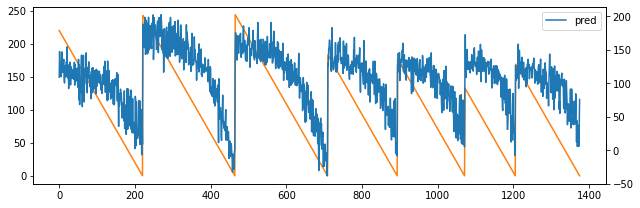

In [175]:
trs_pred = model1.predict(trs_s[dt_in]).ravel() * trmaxrul
stop = 1400 
utils.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

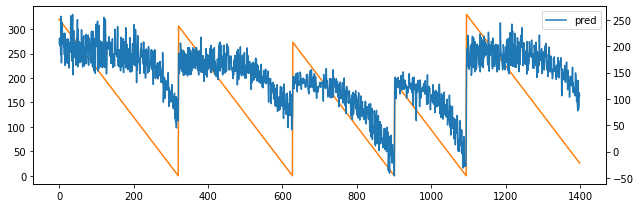

In [176]:
tru_pred = model1.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

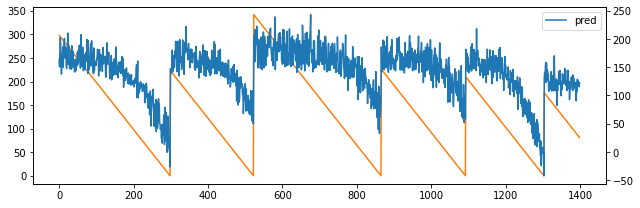

In [177]:
ts_pred = model1.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

Optimal threshold for the training set: 6


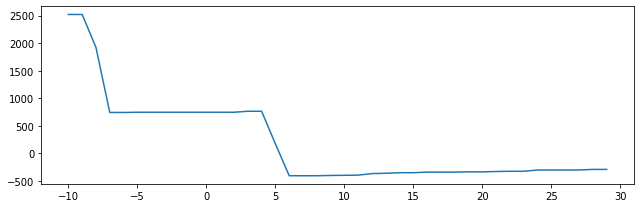

In [178]:
failtimes = dt.groupby('machine')['cycle'].max() 
safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-10, 30)
trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

In [179]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -404 (supervised), 39896 (unsupervised), 11801 (test)


In [180]:
trs_mcn = trs["machine"].unique()
tru_mcn = tru["machine"].unique()
ts_mcn = ts["machine"].unique()


trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.47 (unsupervised), 0.46 (test)
Avg. slack: 10.86 (supervised), 7.32 (unsupervised), 7.59 (test)


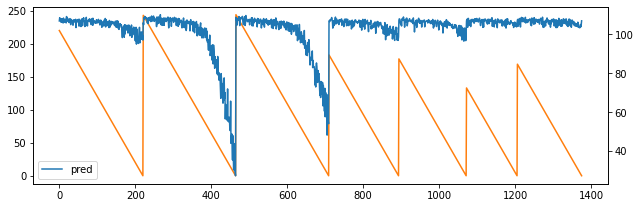

In [183]:
trs_pred = model2.predict(trs_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

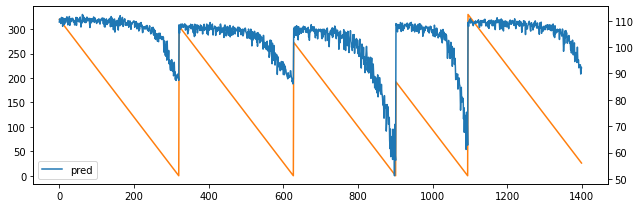

In [184]:
tru_pred = model2.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

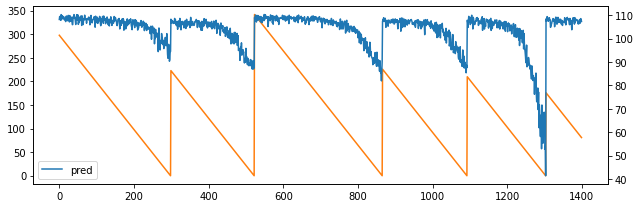

In [185]:
ts_pred = model2.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

Optimal threshold for the training set: 104


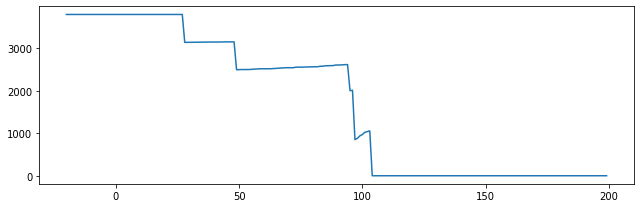

In [186]:
cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-20, 200)
trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

In [187]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: 0 (supervised), -2412 (unsupervised), -342 (test)


In [188]:
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.03 (unsupervised), 0.04 (test)
Avg. slack: 172.14 (supervised), 130.04 (unsupervised), 155.29 (test)


## 23% Supervised 55% unsupervised

In [189]:
trs_ratio = trs_ratios[1]
tru_ratio = tru_ratios[1]


In [190]:
tr, ts, trs, tru = utils.supervised_unsupervised_split(dt, trs_ratio, tru_ratio, verbose=1)
ts_s, tr_s, trs_s, tru_s, trmaxrul = utils.standardize_and_normalize(ts, tr, trs, tru, dt_in)


tru_st = utils.cut_off(tru_s)
trsu_s = pd.concat((trs_s, tru_st))
trsu_s.loc[tru_st.index, 'rul'] = -1

Num. machine: 7 (supervised), 186 (unsupervised), 56 (test)


In [191]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 1376 (supervised), 45746 (unsupervised), 14127 (test)


In [192]:
model1 = models.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
model1.compile(optimizer='Adam', loss='mse')

history = model1.fit(trs_s[dt_in], trs_s['rul'], batch_size=32, epochs=20, verbose=1)

Epoch 1/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1885
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 6/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 8/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 9/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 10/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 11/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 12/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 13/20
43/43 [==============================

In [193]:
model2 = models.LagDualRULRegressor(input_shape=len(dt_in), maxrul=trmaxrul, hidden=[32, 32])

batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
model2.compile(optimizer='Adam', run_eagerly=False)
history = model2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)


Epoch 1/20
1396/1396 [==============================] - 9s 6ms/step - loss: -9.7614e-04 - mse: 5.9358e-04 - cst: 0.0019
Epoch 2/20
1396/1396 [==============================] - 8s 6ms/step - loss: -7.2947e-04 - mse: 3.4590e-04 - cst: 5.5087e-04
Epoch 3/20
1396/1396 [==============================] - 8s 6ms/step - loss: -8.9092e-04 - mse: 3.6057e-04 - cst: 4.4649e-04
Epoch 4/20
1396/1396 [==============================] - 8s 6ms/step - loss: -0.0011 - mse: 3.7085e-04 - cst: 4.1002e-04
Epoch 5/20
1396/1396 [==============================] - 9s 6ms/step - loss: -0.0014 - mse: 3.7404e-04 - cst: 3.7822e-04
Epoch 6/20
1396/1396 [==============================] - 9s 6ms/step - loss: -0.0018 - mse: 3.7671e-04 - cst: 3.7015e-04
Epoch 7/20
1396/1396 [==============================] - 8s 6ms/step - loss: -0.0022 - mse: 3.8462e-04 - cst: 3.6214e-04
Epoch 8/20
1396/1396 [==============================] - 8s 6ms/step - loss: -0.0025 - mse: 3.9054e-04 - cst: 3.5463e-04
Epoch 9/20
1396/1396 [==========

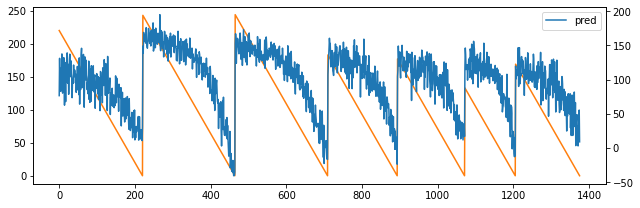

In [194]:
trs_pred = model1.predict(trs_s[dt_in]).ravel() * trmaxrul
stop = 1400 
utils.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

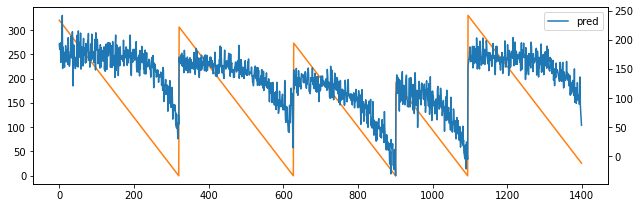

In [195]:
tru_pred = model1.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

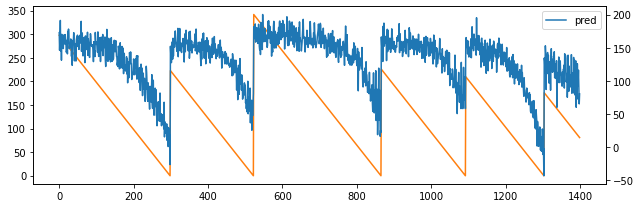

In [196]:
ts_pred = model1.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

Optimal threshold for the training set: 12


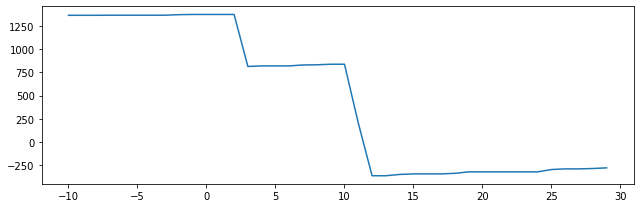

In [197]:
failtimes = dt.groupby('machine')['cycle'].max() 
safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-10, 30)
trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

In [198]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -364 (supervised), 31812 (unsupervised), 9539 (test)


In [199]:
trs_mcn = trs["machine"].unique()
tru_mcn = tru["machine"].unique()
ts_mcn = ts["machine"].unique()


trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.40 (unsupervised), 0.39 (test)
Avg. slack: 17.00 (supervised), 10.40 (unsupervised), 12.86 (test)


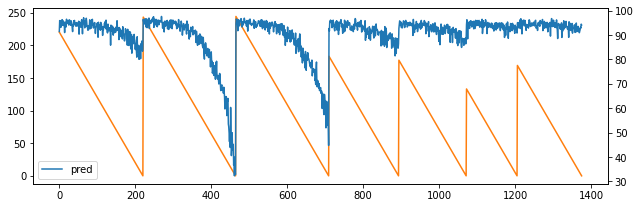

In [200]:
trs_pred = model2.predict(trs_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

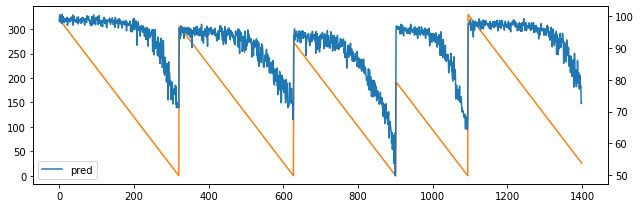

In [201]:
tru_pred = model2.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

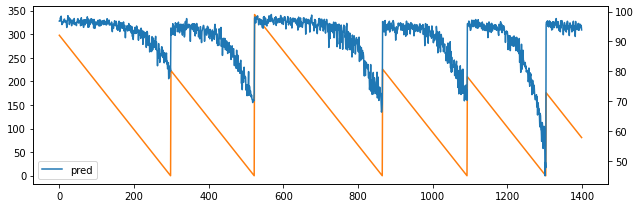

In [202]:
ts_pred = model2.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

Optimal threshold for the training set: 89


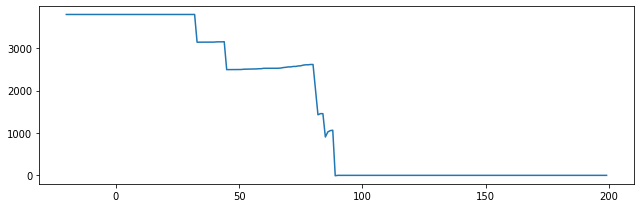

In [203]:
cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-20, 200)
trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

In [204]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -9 (supervised), -1540 (unsupervised), 104 (test)


In [205]:
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.05 (unsupervised), 0.07 (test)
Avg. slack: 97.14 (supervised), 98.54 (unsupervised), 112.57 (test)


## 43% Supervised 35% unsupervised

In [206]:
trs_ratio = trs_ratios[2]
tru_ratio = tru_ratios[2]

In [207]:
np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)
sep_trs = int(trs_ratio * len(machines))
sep_tru = int(tru_ratio * len(machines))
print(sep_trs)
trs_mcn = list(machines[:sep_trs])
tru_mcn = list(machines[sep_trs:sep_tru])
ts_mcn = list(machines[sep_tru:])
tr, ts = utils.partition_by_machine(dt, trs_mcn + tru_mcn)
trs, tru = utils.partition_by_machine(tr, trs_mcn)

print(f'Num. machine: {len(trs_mcn)} (supervised), {len(tru_mcn)} (unsupervised), {len(ts_mcn)} (test)')

112
Num. machine: 112 (supervised), 0 (unsupervised), 150 (test)


In [208]:
tr, ts, trs, tru = utils.supervised_unsupervised_split(dt, trs_ratio, tru_ratio, verbose=1)
ts_s, tr_s, trs_s, tru_s, trmaxrul = utils.standardize_and_normalize(ts, tr, trs, tru, dt_in)


tru_st = utils.cut_off(tru_s)
trsu_s = pd.concat((trs_s, tru_st))
trsu_s.loc[tru_st.index, 'rul'] = -1

Num. machine: 7 (supervised), 186 (unsupervised), 56 (test)


In [209]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 1376 (supervised), 45746 (unsupervised), 14127 (test)


In [210]:
model1 = models.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
model1.compile(optimizer='Adam', loss='mse')

history = model1.fit(trs_s[dt_in], trs_s['rul'], batch_size=32, epochs=20, verbose=1)

Epoch 1/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 6/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 8/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 9/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 10/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 11/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 12/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 13/20
43/43 [==============================

In [211]:
model2 = models.LagDualRULRegressor(input_shape=len(dt_in), maxrul=trmaxrul, hidden=[32, 32])

batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
model2.compile(optimizer='Adam', run_eagerly=False)
history = model2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)


Epoch 1/20
1396/1396 [==============================] - 9s 6ms/step - loss: -8.9803e-04 - mse: 5.5900e-04 - cst: 0.0020
Epoch 2/20
1396/1396 [==============================] - 8s 6ms/step - loss: -7.3290e-04 - mse: 3.6126e-04 - cst: 5.7553e-04
Epoch 3/20
1396/1396 [==============================] - 8s 6ms/step - loss: -8.5997e-04 - mse: 3.5358e-04 - cst: 4.5573e-04
Epoch 4/20
1396/1396 [==============================] - 8s 6ms/step - loss: -0.0011 - mse: 3.8535e-04 - cst: 4.0310e-04
Epoch 5/20
1396/1396 [==============================] - 9s 6ms/step - loss: -0.0014 - mse: 3.7366e-04 - cst: 3.7552e-04
Epoch 6/20
1396/1396 [==============================] - 8s 6ms/step - loss: -0.0017 - mse: 3.5533e-04 - cst: 3.6497e-04
Epoch 7/20
1396/1396 [==============================] - 8s 6ms/step - loss: -0.0021 - mse: 3.6713e-04 - cst: 3.6001e-04
Epoch 8/20
1396/1396 [==============================] - 9s 6ms/step - loss: -0.0025 - mse: 3.7301e-04 - cst: 3.5554e-04
Epoch 9/20
1396/1396 [==========

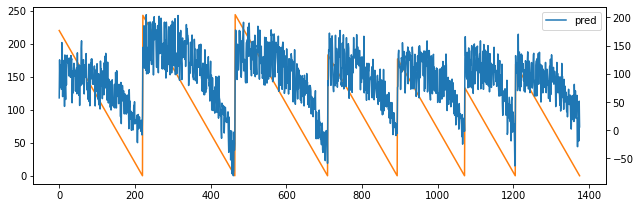

In [212]:
trs_pred = model1.predict(trs_s[dt_in]).ravel() * trmaxrul
stop = 1400 
utils.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

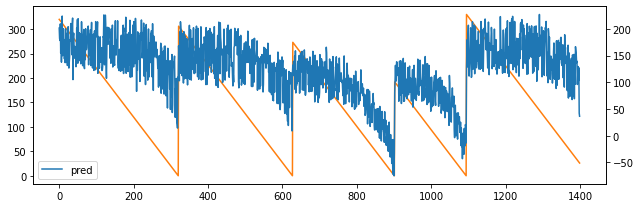

In [213]:
tru_pred = model1.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

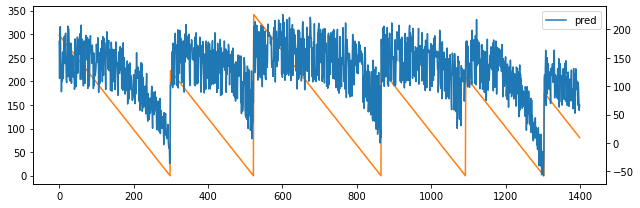

In [214]:
ts_pred = model1.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

Optimal threshold for the training set: -9


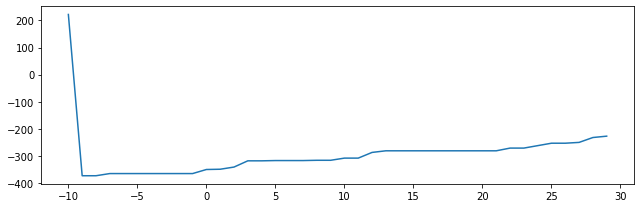

In [215]:
failtimes = dt.groupby('machine')['cycle'].max() 
safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-10, 30)
trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

In [216]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -373 (supervised), 36016 (unsupervised), 10068 (test)


In [217]:
trs_mcn = trs["machine"].unique()
tru_mcn = tru["machine"].unique()
ts_mcn = ts["machine"].unique()


trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.44 (unsupervised), 0.41 (test)
Avg. slack: 16.14 (supervised), 7.10 (unsupervised), 7.07 (test)


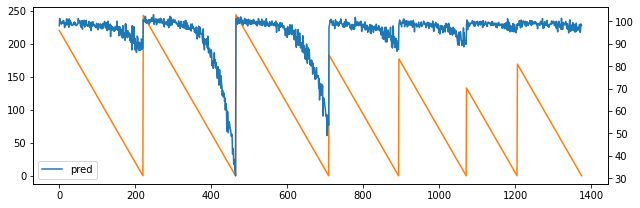

In [218]:
trs_pred = model2.predict(trs_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

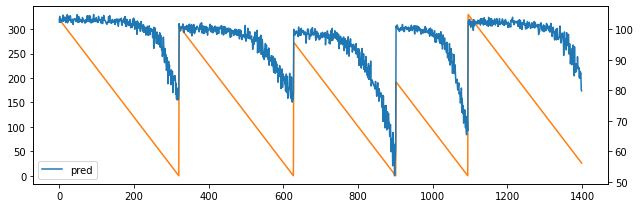

In [219]:
tru_pred = model2.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

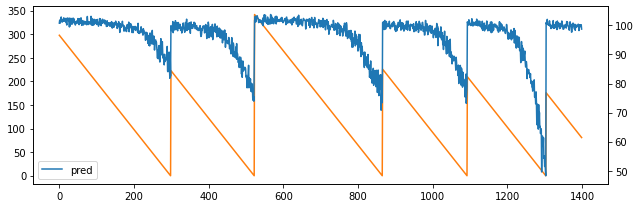

In [220]:
ts_pred = model2.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

Optimal threshold for the training set: 95


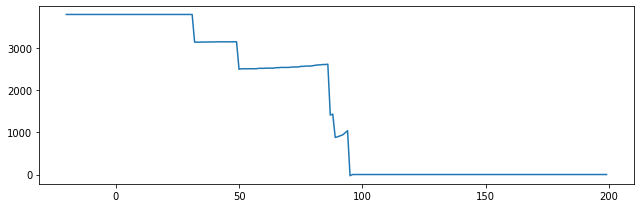

In [221]:
cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-20, 200)
trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

In [222]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -29 (supervised), -4277 (unsupervised), -1544 (test)


In [223]:
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.04 (unsupervised), 0.04 (test)
Avg. slack: 70.29 (supervised), 87.66 (unsupervised), 95.23 (test)


## 63% Supervised 15% unsupervised

In [224]:
trs_ratio = trs_ratios[2]
tru_ratio = tru_ratios[2]

In [225]:
tr, ts, trs, tru = utils.supervised_unsupervised_split(dt, trs_ratio, tru_ratio, verbose=1)
ts_s, tr_s, trs_s, tru_s, trmaxrul = utils.standardize_and_normalize(ts, tr, trs, tru, dt_in)


tru_st = utils.cut_off(tru_s)
trsu_s = pd.concat((trs_s, tru_st))
trsu_s.loc[tru_st.index, 'rul'] = -1

Num. machine: 7 (supervised), 186 (unsupervised), 56 (test)


In [226]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 1376 (supervised), 45746 (unsupervised), 14127 (test)


In [228]:
model1 = models.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
model1.compile(optimizer='Adam', loss='mse')

history = model1.fit(trs_s[dt_in], trs_s['rul'], batch_size=32, epochs=20, verbose=1)

Epoch 1/20
43/43 [==============================] - 0s 2ms/step - loss: 0.5548
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4/20
43/43 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 6/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 8/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 9/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 10/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 11/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 12/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 13/20
43/43 [==============================

In [229]:
model2 = models.LagDualRULRegressor(input_shape=len(dt_in), maxrul=trmaxrul, hidden=[32, 32])

batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
model2.compile(optimizer='Adam', run_eagerly=False)
history = model2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)


Epoch 1/20
1396/1396 [==============================] - 9s 6ms/step - loss: -0.0013 - mse: 9.9429e-04 - cst: 0.0062
Epoch 2/20
1396/1396 [==============================] - 8s 6ms/step - loss: -5.6679e-04 - mse: 3.5603e-04 - cst: 9.9121e-04
Epoch 3/20
1396/1396 [==============================] - 8s 6ms/step - loss: -5.8030e-04 - mse: 2.9303e-04 - cst: 7.9190e-04
Epoch 4/20
1396/1396 [==============================] - 8s 6ms/step - loss: -6.5762e-04 - mse: 3.0230e-04 - cst: 6.0029e-04
Epoch 5/20
1396/1396 [==============================] - 9s 6ms/step - loss: -8.1553e-04 - mse: 3.3117e-04 - cst: 5.1113e-04
Epoch 6/20
1396/1396 [==============================] - 9s 6ms/step - loss: -9.8308e-04 - mse: 3.3973e-04 - cst: 4.3124e-04
Epoch 7/20
1396/1396 [==============================] - 9s 6ms/step - loss: -0.0012 - mse: 3.5037e-04 - cst: 3.8944e-04
Epoch 8/20
1396/1396 [==============================] - 8s 6ms/step - loss: -0.0016 - mse: 3.6615e-04 - cst: 3.7063e-04
Epoch 9/20
1396/1396 [==

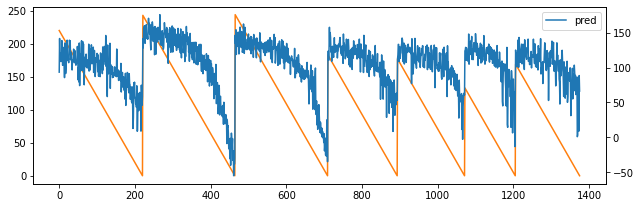

In [230]:
trs_pred = model1.predict(trs_s[dt_in]).ravel() * trmaxrul
stop = 1400 
utils.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

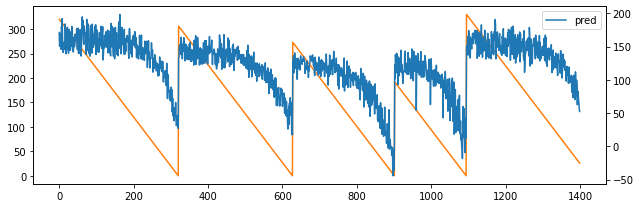

In [231]:
tru_pred = model1.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

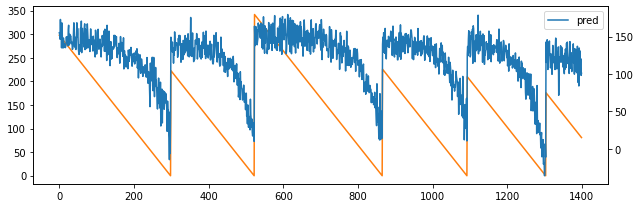

In [232]:
ts_pred = model1.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

Optimal threshold for the training set: 9


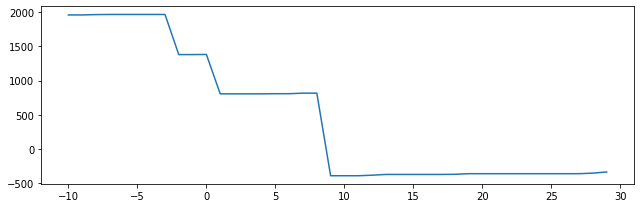

In [233]:
failtimes = dt.groupby('machine')['cycle'].max() 
safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-10, 30)
trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

In [234]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -391 (supervised), 27353 (unsupervised), 8780 (test)


In [235]:
trs_mcn = trs["machine"].unique()
tru_mcn = tru["machine"].unique()
ts_mcn = ts["machine"].unique()


trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.38 (unsupervised), 0.39 (test)
Avg. slack: 13.00 (supervised), 11.30 (unsupervised), 10.57 (test)


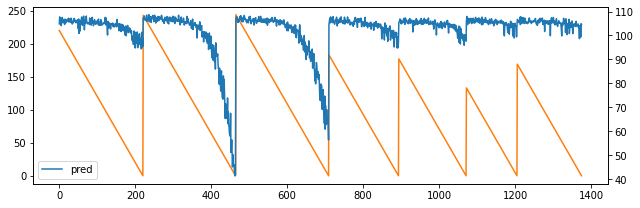

In [236]:
trs_pred = model2.predict(trs_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

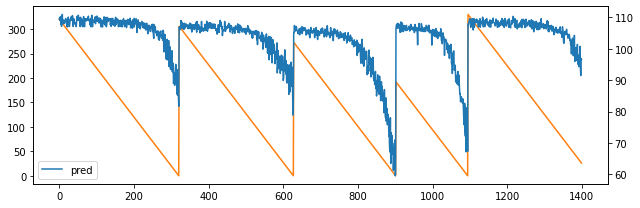

In [237]:
tru_pred = model2.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

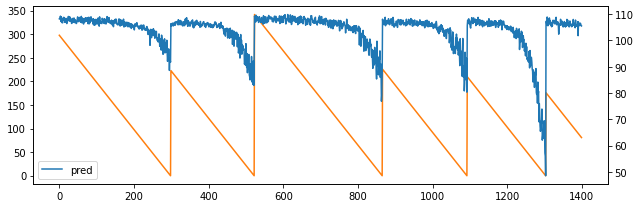

In [238]:
ts_pred = model2.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

Optimal threshold for the training set: 99


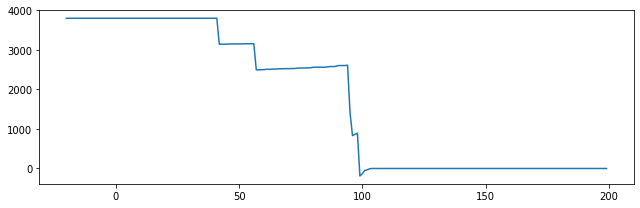

In [239]:
cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-20, 200)
trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

In [240]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -188 (supervised), -6551 (unsupervised), -2529 (test)


In [241]:
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.06 (unsupervised), 0.05 (test)
Avg. slack: 42.00 (supervised), 48.83 (unsupervised), 51.20 (test)
